In [1]:
%matplotlib inline
%load_ext autoreload

import numpy as np
import pandas as pd
from beamforming import curvedWaveFront, timeDomain
from kam11 import thermister, context, rayModeling
from atpy import bellhop, arrivals
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
from scipy import interpolate
import os
from collections import OrderedDict

In [2]:
timeOfInterest='2011 J184 03:51'
tof = dt.datetime.strptime(timeOfInterest, '%Y J%j %H:%M')
numTheta=300
thetaRange=(-8,8)
bellhopFilesDir = '/Users/edwardlrichards/cir_processing/bellhopFiles/beamforming'
bellhopFigDir = '/Users/edwardlrichards/cir_processing/bellhopFiles/beamforming/figs'
# simulated sampling axis
winStart=1.956
winEnd=1.965
fs=1e6
#Number of beamforming times
numWindow=300
beamformingStart=1.959
beamformingEnd=1.964

#figure saving
figSaveDir='/Users/edwardlrichards/cir_processing/beamforming_072915'

In [3]:
%autoreload
ssp = thermister.getSoundSpeed(tof)
rd=context.VLA1(tof).phoneDepths()
arr=rayModeling.getBellhopArrivals(tof,\
                bellhopFilesDir=bellhopFilesDir)

AttributeError: 'receiverArray' object has no attribute 'arrayDepths'

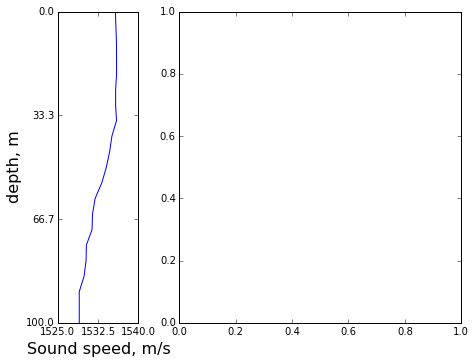

In [6]:
%autoreload
title='Arrival structure for %s'%tof.strftime('J%j %H:%M')
figName=tof.strftime('J%j_%H_%M_Arrivals')
fig=bellhop.plotArrivalSpark(title, ssp, arr,\
    figDir=None, figName=figName)

In [ ]:
arr=arrivals.receiverArray(rd,arrivals_list)
arr.magnitudeOffset(0)
arr.filterArrivals(numTopBounces=1,\
                   angleBounds=[0,10],arrivalMagnitude=-90)

In [ ]:
simData=arr.sampleArrivals(fs,winStart,winEnd,useFilter=True)

In [ ]:
simDB=20*np.log10(np.abs(np.array(simData.T))+np.spacing(1))
simDB-=np.max(simDB)
X,Y=np.meshgrid(simData.index, rd)
_=plt.pcolormesh(X,Y,simDB,\
            vmin=-40,vmax=0,cmap=plt.cm.gnuplot2_r)
_=plt.ylim(100,40)
_=plt.xlim(1.956,1.964)
#set up labels
_=plt.ylabel('depth, m')
_=plt.xlabel('time, s')
_=plt.title('Isolated first arrivals')
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
plt.gca().xaxis.set_major_formatter(x_formatter)
savename='ia_%s'%tof.strftime('J%j_%H_%M')
plt.savefig(os.path.join(figSaveDir,savename))
# _=plt.colorbar()

In [ ]:
thetaTest=np.r_[thetaRange[0]:thetaRange[1]:1j*numTheta]
testDelay=curvedWaveFront.getDelays(thetaTest, ssp, rd, rd[1])
centerTime=np.r_[beamformingStart:beamformingEnd:1j*numWindow]
beams=timeDomain.timeBeamformer(simData, centerTime, testDelay)

In [ ]:
lookDB=20*np.log10(np.abs(np.array(beams))+np.spacing(1))
lookDB-=np.max(lookDB)
X,Y=np.meshgrid(centerTime,thetaTest)
fig,ax=plt.subplots()
pc=ax.pcolormesh(X,Y,lookDB.T,vmin=-40,vmax=0,cmap=plt.cm.gnuplot2_r)
cb=fig.colorbar(pc)

#put bellhop predictions on same plot
# arr.filterArrivals(arrivalMagnitude=-100)
ax.plot(arr.angles[0].index,arr.angles[0],'ko',\
        fillstyle=u'none',markersize=10)

ax.set_ylim(-8,8)
ax.set_xlim(1.959,1.963)
# _=cb.set_ticks([-40,-30-20,-10,0])
_=ax.set_xlim(beamformingStart,beamformingEnd)
#set up labels
_=plt.ylabel('angle, deg')
_=plt.xlabel('time, s')
_=plt.title('Beamforming result for isolated first arrivals\n'+\
           'Bellhop angle plotted as circles')
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
ax.xaxis.set_major_formatter(x_formatter)
savename='iaBeams_%s'%tof.strftime('J%j_%H_%M')
fig.savefig(os.path.join(figSaveDir,savename))